<a href="https://colab.research.google.com/github/chielgroen1998/DL_group_22/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!pip install tensorflow
!pip install --upgrade opencv-python



In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from skimage.feature import local_binary_pattern
from skimage.measure import shannon_entropy


because the zip is large and we are going to use colab we are downloading it straight into the colab this way for quality of life.

In [ ]:
# to download from
file_id = "1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD"
!gdown --id {file_id} -O rare_species.zip




/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD
From (redirected): https://drive.google.com/uc?id=1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD&confirm=t&uuid=2e56ed4a-1509-4317-9e70-2c2b4956fd60
To: /content/rare_species.zip
100% 4.26G/4.26G [01:29<00:00, 47.5MB/s]


In [ ]:
# verify file size
!ls -lh rare_species.zip

-rw-r--r-- 1 root root 4.0G Mar 10 10:29 rare_species.zip


In [ ]:
# directory creation for excation
extract_path = '/content/rare_species'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")

Created directory: /content/rare_species


In [ ]:
# extraction
print("Extracting zip ")
with zipfile.ZipFile('rare_species.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete")

Extracting zip 
Extraction complete


In [ ]:
# list fo contents for double-check
!ls -la {extract_path}



total 2920
drwxr-xr-x 204 root root   12288 Mar 21 13:15 .
drwxr-xr-x   1 root root    4096 Mar 21 13:14 ..
drwxr-xr-x   2 root root   12288 Mar 21 13:15 arthropoda_apidae
drwxr-xr-x   2 root root    4096 Mar 21 13:15 arthropoda_attelabidae
drwxr-xr-x   2 root root    4096 Mar 21 13:15 arthropoda_carabidae
drwxr-xr-x   2 root root    4096 Mar 21 13:14 arthropoda_cerambycidae
drwxr-xr-x   2 root root    4096 Mar 21 13:14 arthropoda_coenagrionidae
drwxr-xr-x   2 root root   20480 Mar 21 13:14 arthropoda_formicidae
drwxr-xr-x   2 root root    4096 Mar 21 13:15 arthropoda_gomphidae
drwxr-xr-x   2 root root    4096 Mar 21 13:15 arthropoda_lucanidae
drwxr-xr-x   2 root root    4096 Mar 21 13:15 arthropoda_nymphalidae
drwxr-xr-x   2 root root    4096 Mar 21 13:15 arthropoda_palinuridae
drwxr-xr-x   2 root root    4096 Mar 21 13:14 arthropoda_papilionidae
drwxr-xr-x   2 root root    4096 Mar 21 13:15 arthropoda_pisauridae
drwxr-xr-x   2 root root    4096 Mar 21 13:15 arthropoda_platystictidae


In [ ]:
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

if csv_files:
    metadata_path = os.path.join(extract_path, csv_files[0])
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print(metadata.head())
else:
    print("No CSV file found.")




Found CSV files: ['metadata.csv']
Loaded metadata with shape: (11983, 7)
                        rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_tur

# **EDA:**

A: Class distribution analysis: checking families for overrepresenation, if present, data augmentation is a possible conclusion (for class imbalance)

B: Image Quality and Resolution check: Are all images consistent size and quality

C: Color Distribution Across Species: What are distinguishing factoes, (color, texture, shape)

D: Shape & Texture features: Are species classified by color, shape, patterns or textures? > try Sobel, Canny, or Histograms

# A

In [ ]:



# Initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Using TPU:", tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default to CPU/GPU
    print("Using CPU/GPU")

# Define paths
DATA_DIR = '/content/rare_species'
processed_data_path = '/content/processed_data'
metadata_path = os.path.join(DATA_DIR, 'metadata.csv')

# Create processed data directory
if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

# Load metadata
metadata = pd.read_csv(metadata_path)


Using CPU/GPU


In [10]:
def resize_and_save_images():
    for idx, row in metadata.iterrows():
        img_path = os.path.join(DATA_DIR, row['file_path'])
        processed_img_path = os.path.join(processed_data_path, row['file_path'])
        os.makedirs(os.path.dirname(processed_img_path), exist_ok=True)

        try:
            img = Image.open(img_path)
            img = img.resize((256, 256))  # Resize to 256x256
            img.save(processed_img_path)
            print(f"Saved: {processed_img_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Run the function to resize and save images
resize_and_save_images()

Streaming output truncated to the last 5000 lines.
Saved: /content/processed_data/chordata_carcharhinidae/21723990_46559790_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_plethodontidae/22778505_1025413_eol-full-size-copy.jpg
Saved: /content/processed_data/arthropoda_nymphalidae/29698419_152379_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_merlucciidae/22323734_46564942_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_diomedeidae/22270115_45511267_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_charadriidae/20245678_1049111_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_fringillidae/30033991_45518969_eol-full-size-copy.jpg
Saved: /content/processed_data/arthropoda_pseudophasmatidae/29945332_1077217_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_serranidae/2700631_46579619_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_geoemydidae/20969393_793083_eol-full-size-copy.jpg
Saved: /c

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Saved: /content/processed_data/mollusca_cardiidae/30003931_46473744_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_pleuronectidae/27808050_46570095_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_salamandridae/8973886_1048040_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_atelidae/28508463_323933_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_dasyatidae/29014729_52572074_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_syngnathidae/2719082_46567809_eol-full-size-copy.jpg
Saved: /content/processed_data/arthropoda_formicidae/29638866_889096_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_cuculidae/14095642_1064877_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_gymnuridae/22078989_46560977_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_burhinidae/28928764_45518912_eol-full-size-copy.jpg
Saved: /content/processed_data/chordata_viperidae/20908296_1057051_eol-full-size-

Number of unique families: 202
Top 10 most common families:
family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
plethodontidae     270
bovidae            240
bucerotidae        210
acroporidae        210
diomedeidae        180
Name: count, dtype: int64


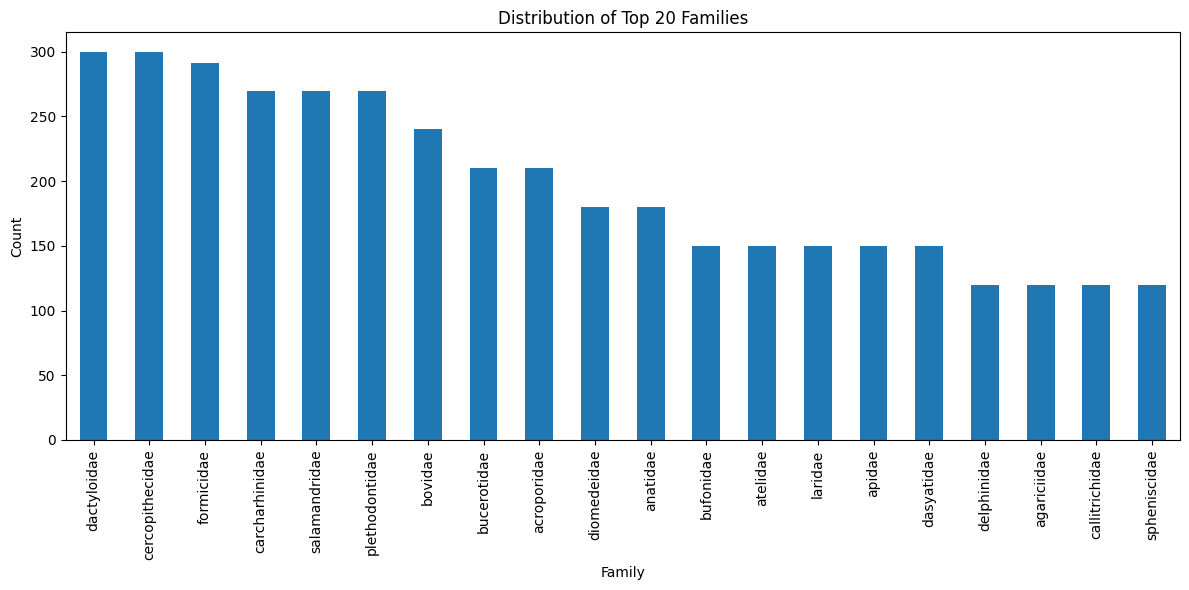

In [11]:
# image distribution p family
if 'family' in metadata.columns:
    family_counts = metadata['family'].value_counts()
    print(f"Number of unique families: {len(family_counts)}")
    print("Top 10 most common families:")
    print(family_counts.head(10))

    plt.figure(figsize=(12, 6))
    family_counts.head(20).plot(kind='bar')
    plt.title('Distribution of Top 20 Families')
    plt.xlabel('Family')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()



The bar chart shows the distribution of the top 20 families in the dataset, and there's clear class imbalance:

The top families (actyloidae, cercopithecidae, formicidae) have around 300 samples each
The middle-tier families have approximately 150-200 samples
The bottom families (dasypodidae, agamidae, callitrichidae, spheriiscidae) have only about 120 samples each

This represents roughly a 2.5:1 ratio between the most and least represented families, which is significant but not extreme. Data augmentation would be beneficial for the underrepresented families to balance the training data. This could involve techniques like rotation, scaling, flipping, or other transformations to artificially increase the sample size of the smaller classes.

# B

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Image Resolution Analysis (Before Resizing):
Unique resolutions: 5229
Average width: 1924.6 ± 1267.5
Average height: 1512.3 ± 951.3


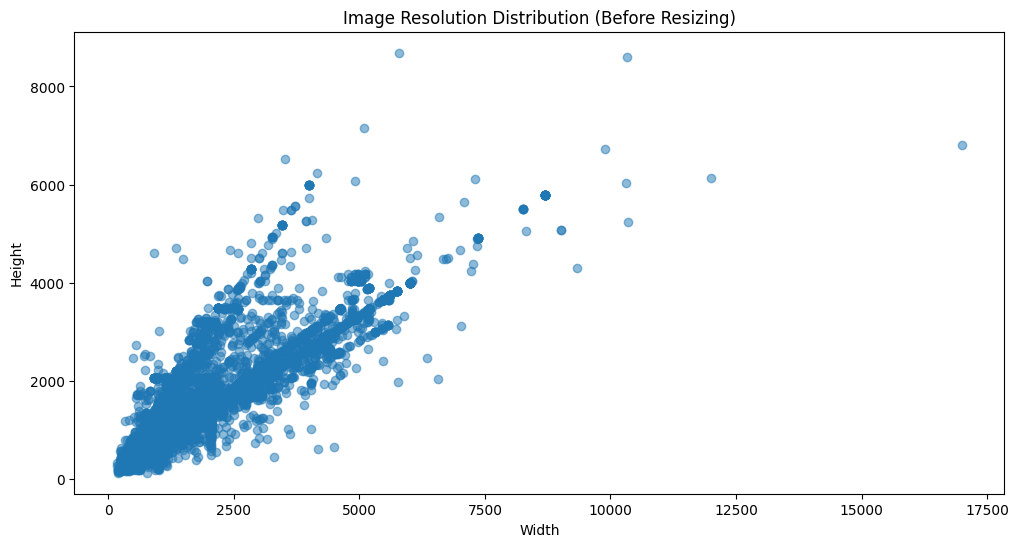


Image Resolution Analysis (After Resizing):
Unique resolutions: 1
Average width: 256.0 ± 0.0
Average height: 256.0 ± 0.0


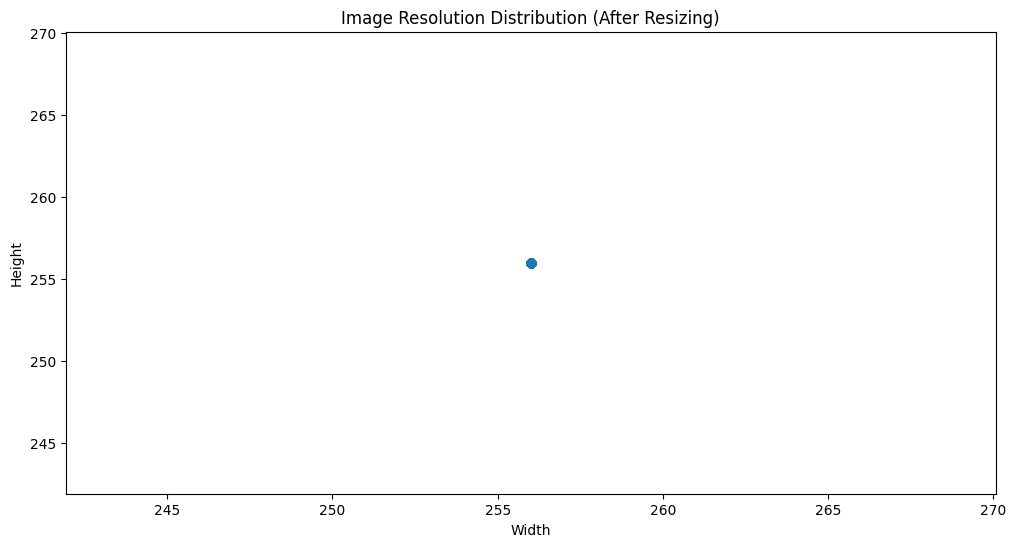

In [12]:
# image dimensions (before resizing)
if 'file_path' in metadata.columns:
    resolutions = []
    for idx, row in metadata.iterrows():
        img_path = os.path.join(DATA_DIR, row['file_path'])
        try:
            with Image.open(img_path) as img:
                resolutions.append(img.size)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue

    if resolutions:

        unique_resolutions = pd.Series(resolutions).value_counts()
        width, height = zip(*resolutions)

        print("\nImage Resolution Analysis (Before Resizing):")
        print(f"Unique resolutions: {len(unique_resolutions)}")
        print(f"Average width: {np.mean(width):.1f} ± {np.std(width):.1f}")
        print(f"Average height: {np.mean(height):.1f} ± {np.std(height):.1f}")

        plt.figure(figsize=(12, 6))
        plt.scatter(width, height, alpha=0.5)
        plt.title('Image Resolution Distribution (Before Resizing)')
        plt.xlabel('Width')
        plt.ylabel('Height')
        plt.show()
    else:
        print("\nNo images were successfully loaded for resolution analysis.")

# image dimensions (after resizing)
if 'file_path' in metadata.columns:
    resolutions = []
    for idx, row in metadata.iterrows():
        img_path = os.path.join(processed_data_path, row['file_path'])
        try:
            with Image.open(img_path) as img:
                resolutions.append(img.size)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue

    if resolutions:
        unique_resolutions = pd.Series(resolutions).value_counts()
        width, height = zip(*resolutions)

        print("\nImage Resolution Analysis (After Resizing):")
        print(f"Unique resolutions: {len(unique_resolutions)}")
        print(f"Average width: {np.mean(width):.1f} ± {np.std(width):.1f}")
        print(f"Average height: {np.mean(height):.1f} ± {np.std(height):.1f}")

        # resolution distribution
        plt.figure(figsize=(12, 6))
        plt.scatter(width, height, alpha=0.5)
        plt.title('Image Resolution Distribution (After Resizing)')
        plt.xlabel('Width')
        plt.ylabel('Height')
        plt.show()
    else:
        print("\nNo images were successfully loaded for resolution analysis.")

Most images cluster in the lower resolution range (under 5000 pixels in width and 3000 pixels in height)
There are outliers with much higher resolutions, with some reaching up to 17,500 pixels wide
The distribution shows a positive correlation between width and height, which is expected
There appears to be multiple distinct clusters, suggesting perhaps different image sources or capture methods

Removal of outliers may be desired

# C

In [13]:
# colour distribution analysis
if 'family' in metadata.columns:
    color_stats = []

    for idx, row in metadata.iterrows():
        img_path = os.path.join(processed_data_path, row['file_path'])
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                color_stats.append({
                    'family': row['family'],
                    'mean_r': np.mean(img[:,:,0]),
                    'mean_g': np.mean(img[:,:,1]),
                    'mean_b': np.mean(img[:,:,2])
                })
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    color_df = pd.DataFrame(color_stats)

    # Print summary statistics
    print("Summary Statistics for Color Channels by Family:")
    summary_stats = color_df.groupby('family').agg({
        'mean_r': ['mean', 'median', 'std'],
        'mean_g': ['mean', 'median', 'std'],
        'mean_b': ['mean', 'median', 'std']
    })
    print(summary_stats)

Summary Statistics for Color Channels by Family:
                      mean_r                             mean_g              \
                        mean      median        std        mean      median   
family                                                                        
accipitridae      133.208153  128.771515  41.930585  142.754990  143.954712   
acipenseridae     142.769582  135.817986  58.683246  135.945280  125.333069   
acroporidae        97.226581   93.792847  32.179803   99.764513   98.482895   
agamidae          111.023355  120.603012  58.540265  102.445272  111.972733   
agariciidae       113.289581  115.483223  46.281531  114.115744  111.369705   
...                      ...         ...        ...         ...         ...   
vespertilionidae   99.224813  101.208229  39.264651   97.434685   98.755341   
viperidae         123.009260  118.894447  35.549663  116.515307  116.938522   
vireonidae        123.909702  112.090149  31.970556  136.645073  124.823860   
vom

In [ ]:


pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
summary_stats

**RGB Channel Patterns:**

Most families have higher R values than B values (around 120-140 for R vs. 90-120 for B)
Notable exceptions: Carcharhinidae (sharks) with R: 91.3, G: 120.6, B: 136.7 - shows inverse pattern with blue dominance
Scombridae (mackerels) have similar blue dominance (R: 94.7, G: 116.9, B: 139.7)


**Extreme Values:**

Highest R value: Formicidae (ants) with 156.8 mean R
Lowest R value: Goodeidae (freshwater fish) with 63.9 mean R
Highest G value: Apidae (bees) with 192.2 mean G
Highest B value: Scincidae (skinks) with 165.3 mean B


**Color Consistency:**

Lowest standard deviations: Recurvirostridae (stilts/avocets) with R std: 15.7, G std: 15.1
Highest standard deviations: Pristidae (sawfish) with R std: 68.7, G std: 62.1, B std: 68.1


**Family-Specific Patterns:**

Phyllomedusidae (leaf frogs): Very low B values (50.1) compared to R/G
Scincidae (skinks): Exceptionally high values across all channels (R: 174.3, G: 168.5, B: 165.3)
Apidae (bees): Extremely high values across all channels (R: 191.0, G: 192.2, B: 184.5)


**Channel Correlations:**

Most families show R > G > B pattern
Marine families (Carcharhinidae, Delphinidae) often show B > G > R pattern
Bird families generally show higher G values relative to B


**Mean vs. Median Differences:**

Squatinidae (angel sharks) show large differences between mean and median (R mean: 95.6, R median: 76.4)
Indicates skewed color distributions in these families


**Taxonomic Patterns:**

Reptiles (Chamaeleonidae, Dactyloidae) show low B values (66.2, 67.0)
Primates (Hominidae, Cercopithecidae) show relatively balanced RGB values
Insect families (Formicidae, Apidae) show highest overall brightness


**Standard Deviation Patterns:**

Carcharhinidae (sharks): High R std (61.8) but lower G/B std (44.9/45.0)
Suggests more variability in red channel than blue/green


**Outlier Families:**

Brachypteraciidae (ground rollers): Extremely dark (R: 65.0, G: 63.1, B: 48.8)
Goodeidae (freshwater fish): Unusual pattern with G > R >> B (63.9, 87.9, 38.4)


**Median vs. Mean Relationships:**

Families like Aotidae show large differences (R mean: 161.8, R median: 195.1)
Indicates non-normal distributions - likely bimodal or highly skewed

Preprocessing steps needed:

1. Global Color Normalization (Priority 1)
Why: The extreme brightness differences (e.g., apidae vs. brachypteraciidae) will dominate model training. How: Z-score normalization using global dataset statistics (not per-family):

2. Channel-Ratio Feature Engineering (Priority 1)
Why: Your data shows clear R/B separation between aquatic/terrestrial families.
Implementation: Add R/B ratio and G/(R+B) as explicit features, impact of this will be directly encoding observed patterns (e.g., carcharhinidae R/B = 0.67 vs. cervidae R/B = 1.23).



# D

In [ ]:
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Read as RGB
    return image

file_paths = [os.path.join(processed_data_path, row['file_path']) for _, row in metadata.iterrows()]
dataset = tf.data.Dataset.from_tensor_slices(file_paths)
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).cache().prefetch(tf.data.AUTOTUNE)

# edge detection w Sobel filters on grayscale images
def edge_detection(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
    sobel_x = tf.reshape(sobel_x, [3, 3, 1, 1])
    sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)
    sobel_y = tf.reshape(sobel_y, [3, 3, 1, 1])

    edges_x = tf.nn.conv2d(image, sobel_x, strides=[1, 1, 1, 1], padding='SAME')
    edges_y = tf.nn.conv2d(image, sobel_y, strides=[1, 1, 1, 1], padding='SAME')
    edges = tf.sqrt(tf.square(edges_x) + tf.square(edges_y))
    edges = tf.squeeze(edges)
    return edges

# texture analysis using Local Binary Patterns (LBP)
def texture_analysis(image):
    image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale for texture analysis
    image = image.numpy()  # Convert to NumPy array
    image = np.squeeze(image)  # Remove single-dimensional entries (e.g., convert from (H, W, 1) to (H, W))
    image = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    return lbp



In [ ]:
# a batch of images
for batch in dataset.take(10):  # 10 for large dataset 10k+ images
    original_images = batch
    edge_images = edge_detection(batch)
    texture_images = [texture_analysis(img) for img in batch]

    # plotting
    plt.figure(figsize=(20, 10))
    for i in range(min(5, len(original_images))):  # disp first 5 images
        # original image
        plt.subplot(3, 5, i+1)
        plt.imshow(original_images[i].numpy().astype(np.uint8))
        plt.title('Original')
        plt.axis('off')

        # edge-detected image
        plt.subplot(3, 5, i+6)
        plt.imshow(edge_images[i], cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')

        # texture analysis (LBP)
        plt.subplot(3, 5, i+11)
        plt.imshow(texture_images[i], cmap='gray')
        plt.title('Texture (LBP)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
metrics_df = pd.DataFrame(columns=["file_path", "edge_density", "texture_entropy"])

for batch_num, batch in enumerate(dataset):
    original_images = batch
    edge_images = edge_detection(batch)
    texture_images = [texture_analysis(img) for img in batch]
    batch_file_paths = file_paths[batch_num*32 : (batch_num+1)*32]

    for i, (edge_img, texture_img) in enumerate(zip(edge_images, texture_images)):
        edge_density = tf.reduce_mean(edge_img).numpy()

        hist = np.histogram(texture_img, bins=np.arange(0, 256))[0].astype(float)
        hist /= hist.sum()
        texture_entropy = shannon_entropy(hist)

        metrics_df = pd.concat([
            metrics_df,
            pd.DataFrame([{
                "file_path": batch_file_paths[i],
                "edge_density": edge_density,
                "texture_entropy": texture_entropy
            }])
        ], ignore_index=True)

metrics_df.to_csv(os.path.join(processed_data_path, "image_metrics.csv"), index=False)

print("Metric Summary:")
print(metrics_df[["edge_density", "texture_entropy"]].describe())

<ipython-input-17-32da87f3a0ec>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([


Metric Summary:
       edge_density  texture_entropy
count  11983.000000     11983.000000
mean      29.350763         0.952615
std       16.132494         0.003801
min        1.643982         0.920108
25%       17.081238         0.954441
50%       25.674805         0.954441
75%       38.783356         0.954441
max      108.692078         0.954441


In [18]:
def shannon_entropy(hist):
    hist = hist[hist > 0]  # Remove zero probabilities
    return -np.sum(hist * np.log2(hist))

metrics_list = []
for batch_num, batch in enumerate(dataset):
    batch_size = len(batch)
    original_images = batch
    edge_images = edge_detection(batch)
    texture_images = [texture_analysis(img) for img in batch]

    start_idx = batch_num * batch_size
    end_idx = start_idx + batch_size
    batch_file_paths = file_paths[start_idx:end_idx]

    for i, (edge_img, texture_img) in enumerate(zip(edge_images, texture_images)):
        edge_density = tf.reduce_mean(edge_img).numpy()

        # Texture entropy with proper bin handling
        hist = np.histogram(texture_img, bins=np.arange(0, 257))[0].astype(float)
        hist += 1e-10  # Add epsilon to avoid zeros
        hist /= hist.sum()
        texture_entropy = shannon_entropy(hist)

        metrics_list.append({
            "file_path": batch_file_paths[i],
            "edge_density": edge_density * 100,  # Convert to percentage if needed
            "texture_entropy": texture_entropy
        })

metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("metrics.csv")

normalizing features, edge_density ranges from 265.5 to 8090.12, &texture_entropy ranges from 1.30 to 4.21.

handling skewness via log-transform because edge_density is heavily right-skewed, with extreme values like 7932.87 compared to the median of around 2500.

Add Taxonomic Labels to Metadata

# Preprocessing

Based on the EDA a conclusion will be made to:



1.   deal with distribution image quality and color analysis
2.   test color vs grayscale
3.   identify differentation p species, color shape texture
4.   augmentation for imbalances
5.   unsupervised learning for outliers (unsupervised models dont rely on labels so can find patterns better_
6.   Resizing, when resizing compare accuracy effects, manual re-runs per resolution size to find most fitting one
7.   UMAP/Autoencoder if no social life and bored

